In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import hashlib
import json
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=60)

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2025-10-02 01:33:10.775961
End date: 2025-12-01 01:33:10.775961


In [3]:
gold = yf.download("GC=F", start=start_date, end=end_date, interval="30m", auto_adjust = False)[["Close"]].rename(columns={"Close": "Gold"})
silver = yf.download("SI=F", start=start_date, end=end_date, interval="30m", auto_adjust = False)[["Close"]].rename(columns={"Close": "Silver"})
cad = yf.download("CADUSD=X", start=start_date, end=end_date, interval="30m", auto_adjust = False)[["Close"]].rename(columns={"Close": "CAD"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
all_prices = gold.join([silver, cad], how="outer")
all_prices = all_prices.ffill().bfill()

In [5]:
df = all_prices.copy()

for col in ["Gold", "Silver", "CAD"]:
    df[col+"_ret"] = np.log(df[col]).diff() # bc linear regression works better on statiionary data

df = df.dropna()

In [6]:
# for the time series, it becomes an autoregressive model I think
def create_lag_features(df, target, n_lags=10):
    for lag in range(1, n_lags + 1):
        df[f"{target}_lag_{lag}"] = df[target].shift(lag)
    return df

n_lags = 10

df = create_lag_features(df, "Gold_ret", n_lags)
df = create_lag_features(df, "Silver_ret", n_lags)
df = create_lag_features(df, "CAD_ret", n_lags)

df = df.dropna()

In [7]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

assets = ["Gold", "Silver", "CAD"]

models = {}
predicted_prices = {}

for asset in assets:
    y_train = train_df[f"{asset}_ret"]
    X_train = train_df.filter(like="_lag_")

    X_test = test_df.filter(like="_lag_")
    y_test = test_df[f"{asset}_ret"]

    model = LinearRegression()
    model.fit(X_train, y_train)

    models[asset] = model

    pred_returns = model.predict(X_test)

    # reconstructing predicted price from returns
    last_train_price = train_df[asset].iloc[-1]
    pred_price = [last_train_price]

    for r in pred_returns:
        next_p = pred_price[-1] * np.exp(r)
        pred_price.append(next_p)

    pred_price = pred_price[1:]
    predicted_prices[asset] = pd.Series(pred_price, index=test_df.index)

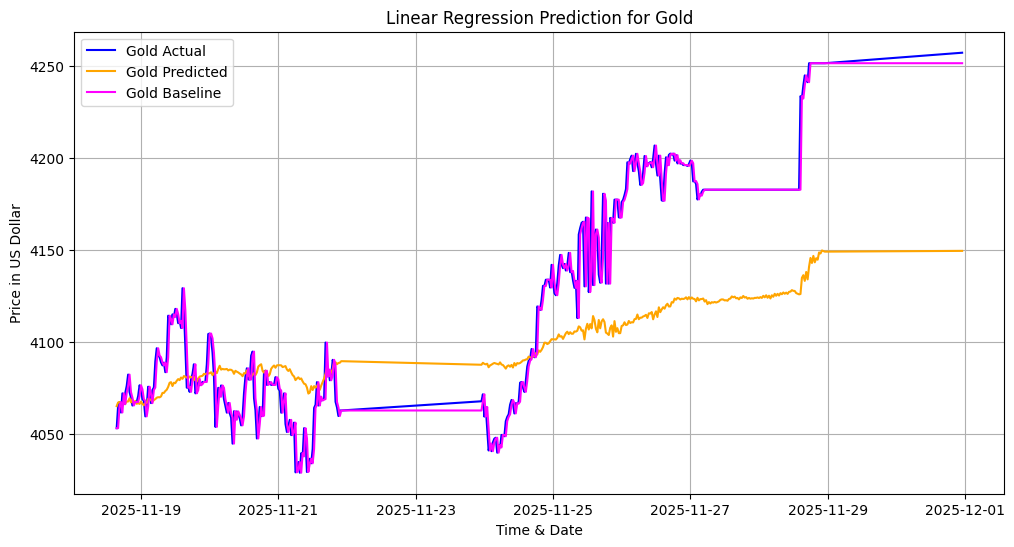

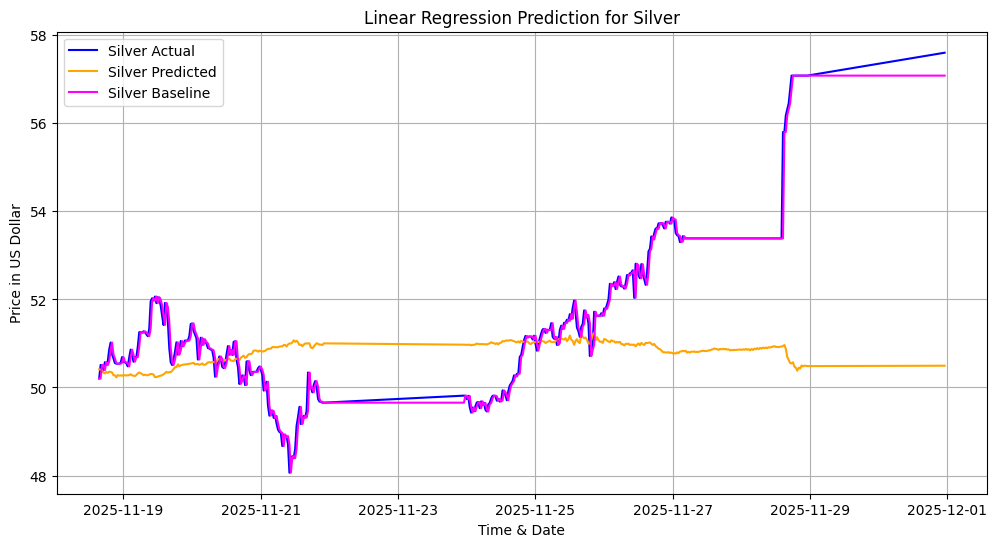

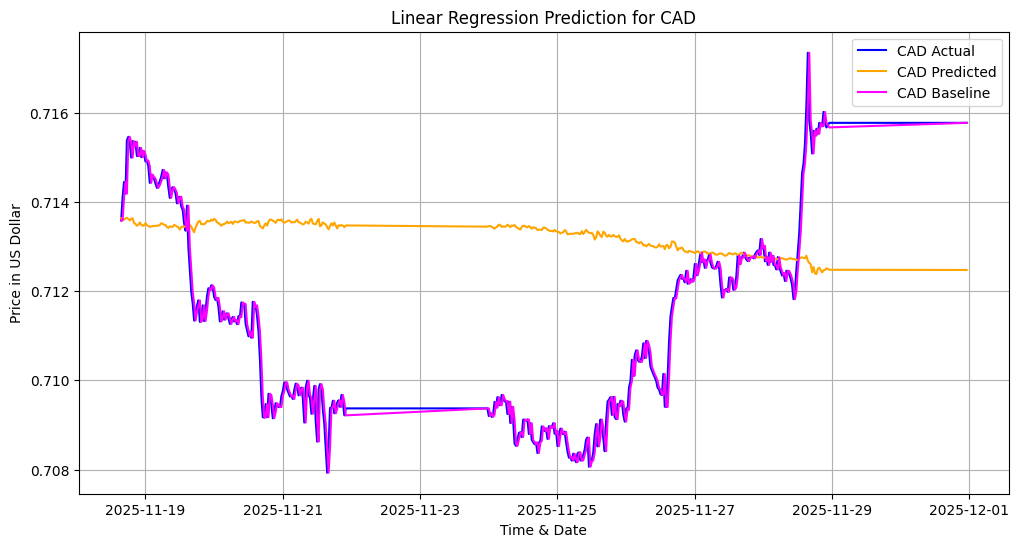

In [9]:
for asset in assets:
    plt.figure(figsize=(12, 6))

    plt.plot(
        test_df.index,
        test_df[asset],
        label=f"{asset} Actual",
        color="blue"
    )

    plt.plot(
        predicted_prices[asset].index,
        predicted_prices[asset],
        label=f"{asset} Predicted",
        color="orange"
    )

    baseline = test_df[asset].shift(1).bfill()  # naive model: next = current
    plt.plot(
        baseline.index,
        baseline,
        label=f"{asset} Baseline",
        color="magenta"
    )

    # -------------------------------
    plt.title(f"Linear Regression Prediction for {asset}")
    plt.xlabel("Time & Date")
    plt.ylabel("Price in US Dollar")
    plt.legend()
    plt.grid(True)
    plt.show()